**StackingClassifier(ensemble) considered in this notebook**

In [11]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,b,auc,roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import jaccard_score

In [2]:
#loading the transformed Data Set
solar_data = pd.read_csv(r"solar_data_transformed18.csv")
print(solar_data.columns)

Index(['ID', 'County', 'InstallType', 'UrbanRural', 'Class', 'Percent_100',
       'Substation_100', 'HIFLD_100', 'Percent_200', 'Substation_200',
       'HIFLD_200', 'Percent_CAISO', 'Substation_CAISO', 'HIFLD_CAISO',
       'SolarTech', 'Area', 'Length', 'DistSub_100_binned',
       'DistSub_200_binned', 'DistSub_CAISO_binned'],
      dtype='object')


In [3]:
X = solar_data.drop(columns=['ID','InstallType'])  # Features
y = solar_data['InstallType']  # Target

Stacking Classifier Accuracy: 0.9185
ROC-AUC Score: 0.9807834071948442

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       427
           1       0.92      0.90      0.91       287
           2       0.92      0.90      0.91       366

    accuracy                           0.92      1080
   macro avg       0.92      0.92      0.92      1080
weighted avg       0.92      0.92      0.92      1080


Confusion Matrix:
 [[405   4  18]
 [ 19 257  11]
 [ 17  19 330]]


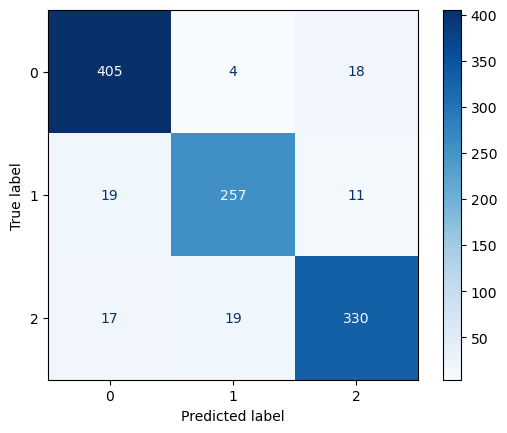

In [4]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base learners
dt = DecisionTreeClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

# Meta learner
lr = LogisticRegression(random_state=42, max_iter=500)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('dt', dt),
        ('svm', svm)
    ],
    final_estimator=lr,
    cv=3,  # Cross-validation
    n_jobs=-1
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Predict on test set
y_pred = stacking_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Stacking Classifier Accuracy: {accuracy:.4f}")
conf_matrix=confusion_matrix(y_test, y_pred)
y_prob = stacking_clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')


Fine tuning the stacking classifier

In [6]:
# Step 3: Define parameter grid for tuning
param_grid = {
    'dt__max_depth': [3, 5],  # limit max depth
    'dt__min_samples_split': [2],  # fewer samples
    'svm__C': [1],  # fixed regularization strength
    'svm__kernel': ['linear'],
    'final_estimator__C': [1]  # keep final estimator simple
}
# Step 4: Use GridSearchCV
grid_search = GridSearchCV(estimator=stacking_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Step 5: Train and find the best parameters
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Step 6: Evaluate on the test set
from sklearn.metrics import classification_report, accuracy_score

y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'dt__max_depth': 5, 'dt__min_samples_split': 2, 'final_estimator__C': 1, 'svm__C': 1, 'svm__kernel': 'linear'}
Test Accuracy: 0.8546296296296296
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       427
           1       0.84      0.81      0.82       287
           2       0.80      0.84      0.82       366

    accuracy                           0.85      1080
   macro avg       0.85      0.85      0.85      1080
weighted avg       0.86      0.85      0.85      1080



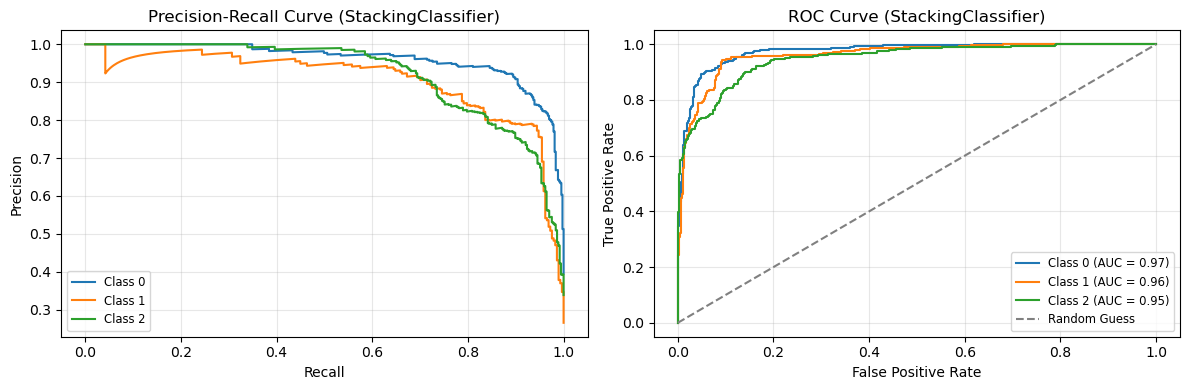

In [7]:
# Ensure binary format for true labels
n_classes = len(best_model.classes_)  # Use classes_ from the StackingClassifier
y_test_bin = label_binarize(y_test, classes=best_model.classes_)  # Binarize the true labels

# Get predicted probabilities from the stacking classifier
y_prob = best_model.predict_proba(X_test)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot Precision-Recall Curves
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    axes[0].plot(recall, precision, label=f"Class {best_model.classes_[i]}")

axes[0].set_title("Precision-Recall Curve (StackingClassifier)", fontsize=12)
axes[0].set_xlabel("Recall", fontsize=10)
axes[0].set_ylabel("Precision", fontsize=10)
axes[0].legend(loc="lower left", fontsize='small')
axes[0].grid(alpha=0.3)

# Plot ROC Curves
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f"Class {best_model.classes_[i]} (AUC = {roc_auc:.2f})")

axes[1].plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
axes[1].set_title("ROC Curve (StackingClassifier)", fontsize=12)
axes[1].set_xlabel("False Positive Rate", fontsize=10)
axes[1].set_ylabel("True Positive Rate", fontsize=10)
axes[1].legend(loc="lower right", fontsize='small')
axes[1].grid(alpha=0.3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [13]:
#Use roc_auc_score with 'ovr' or 'ovo' for multiclass
print("ROC-AUC Score (OVR):", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("ROC-AUC Score (OVO):", roc_auc_score(y_test, y_prob, multi_class='ovo'))
#print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred_dt))
from sklearn.metrics import cohen_kappa_score
kappa_score = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa Score:", kappa_score)
print("Jaccard Score (Macro):", jaccard_score(y_test, y_pred, average='macro'))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))


ROC-AUC Score (OVR): 0.9610820675747825
ROC-AUC Score (OVO): 0.9597956103978987
Cohen's Kappa Score: 0.7791218281980505
Jaccard Score (Macro): 0.7410554645975811
Matthews Correlation Coefficient: 0.7793421891540868


#### Stacking classifier Insights

The stacking classifier tuned with dt and svm as base learners and lr as the final estimator provides an accuracy of 85.46% on a test dataset. Hence, this model shows that class 0, with 427 samples, has attained the highest precision of 0.91 and a recall of 0.89, leading to an F1-score of 0.90. Class 1, with 287 samples, and class 2, with 366 samples, also have good precisions of 0.84 and 0.80 and recall of 0.81 and 0.84, respectively, though somewhat lower than class 0. The precision, recall, and F1-score macro and weighted averages are close to each other; this shows that the model is performing well in balancing all classes. Cross-validation cv=3, for fine-tuning, gave appropriate levels of max_depth in a decision tree or C in the case of the SVM, bringing out an excellent result of robust and generalized models. This includes combining various Classifiers that has significantly enhanced the stacking approach through handling different patterns within the dataset, improving its ability to make predictions and refining those predictions through logistic regression.